# Imports

In [1]:
%pip install scikit-learn
%pip install seaborn
%pip install pandas

import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy

# Tools
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# models
from sklearn.tree import DecisionTreeClassifier

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Definindo Constantes

In [2]:
RANDOM_SEED = 1337
N_JOBS = -1

# Carregamento de dados

In [3]:
def load_data(file_path: str, positive_label_multiplication: int = 2) -> pandas.DataFrame:
    """ Receives a file path for the dataset training, testing and validation datasets. """

    # Loading data from csv file
    df = pandas.read_csv(file_path)

    # Selecting useful features
    useful_features = [
        "Bidder_Tendency",
        "Bidding_Ratio",
        "Successive_Outbidding",
        "Last_Bidding",
        "Auction_Bids",
        "Starting_Price_Average",
        "Early_Bidding",
        "Winning_Ratio",
        "Auction_Duration",
        "Class"
    ]

    df = df[useful_features]

    # Augmenting positive label data
    positive_labels = df[df["Class"] == 1]

    dfs_to_concat = [df]
    for _ in range(positive_label_multiplication):
        dfs_to_concat.append(positive_labels)

    df = pandas.concat(dfs_to_concat)
    df = df.sample(frac=1)

    # Separating features and labels
    columns = list(df.columns)
    features = columns[:len(columns)-1]
    label = columns[len(columns)-1:]

    X = df[features]
    y = df[label]

    # Creating training, testing and validation datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_SEED)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.125, random_state = RANDOM_SEED)

    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [4]:
file_path = "./dataset/Shill Bidding Dataset.csv"

X_train, y_train, X_test, y_test, X_valid, y_valid = load_data(file_path)

# Instanciando modelo

In [5]:
decision_tree = DecisionTreeClassifier(
    criterion= "gini",
    max_depth= 38,
    max_features= None,
    splitter= "random"
)

print("Training decision tree")
start = time.time()

decision_tree.fit(X_train, y_train.values.ravel())

end = round(time.time() - start, 2)
print(f"Training of decision tree completed in {end} seconds")

Training decision tree
Training of decision tree completed in 0.0 seconds


# Checando relevância dos atributos
Utilizamos os atributos presentes numa decision tree treinada (feature_names_in_ e feature_importances_), para determinar quais features são mais relevantes para a decision tree, na hora de classificar.

É importante ressaltar que esses atributos, por si mesmos, não indicam exatamente se a presença ou falta deles é um ótimo indicativo do comportamento fraudulento que desejamos detectar,
mas sim que a decision tree consegue ganhar muita informação ao dividir os registros com base no valor do atributo.

Dito isso, se somarmos o conhecimento obtido nessa análise com o contexto do nosso problema, podemos afirmar com bastante certeza que o atributo mais relevante para a árvore, Successive_Outbidding, é um indicador excelente de comportamento suspeito.

O Successive_Outbidding indica o comportamento muito específico de um usuário que JÁ ESTÁ VENCENDO um leilão, mas CONTINUA A DAR LANCES, CADA VEZ MAIORES.
É um comportamento ilógico que dificilmente partiria de um usuário legítimo, pois faria com que precise pagar mais sem necessidade.
Esse comportamento é exemplar de usuários falsos pertencentes ao dono do item em leilão, ou ao menos relacionados, que fazem isso apenas para inflacionar o valor do item, sem interesse em comprá-lo.

Sendo assim, após analisar o gráfico, as sugestões mais relevante para darmos seriam:
1. Imediatamente cancelar qualquer lance que se enquadre no padrão de Successive_Outbidding e bloquear o usuário responsável, mantendo um canal de comunicação aberto para os casos raros de usuários legítimos que por acaso fizeram isso, sem intenções maliciosas terem a opção de contestar o bloqueio.
2. Criar um alerta automático para a presença dos comportamentos descritos como sendo os 2º, 3º e 4º mais relevantes, que repassa o caso para as IA's desenvolvidas. Embora esses atributos (Auction Duration, Winning_Ration e Last_Bidding) sejam bem menos relevantes que o Successive_Outbidding para a classificação, até por representarem uma range de valores e não exatamente uma categoria, registros com esses valores próximos dos valores médios de comportamento fraudulentos são bastante suspeitos.

Feature Importances:


<AxesSubplot:xlabel='feature', ylabel='importance'>

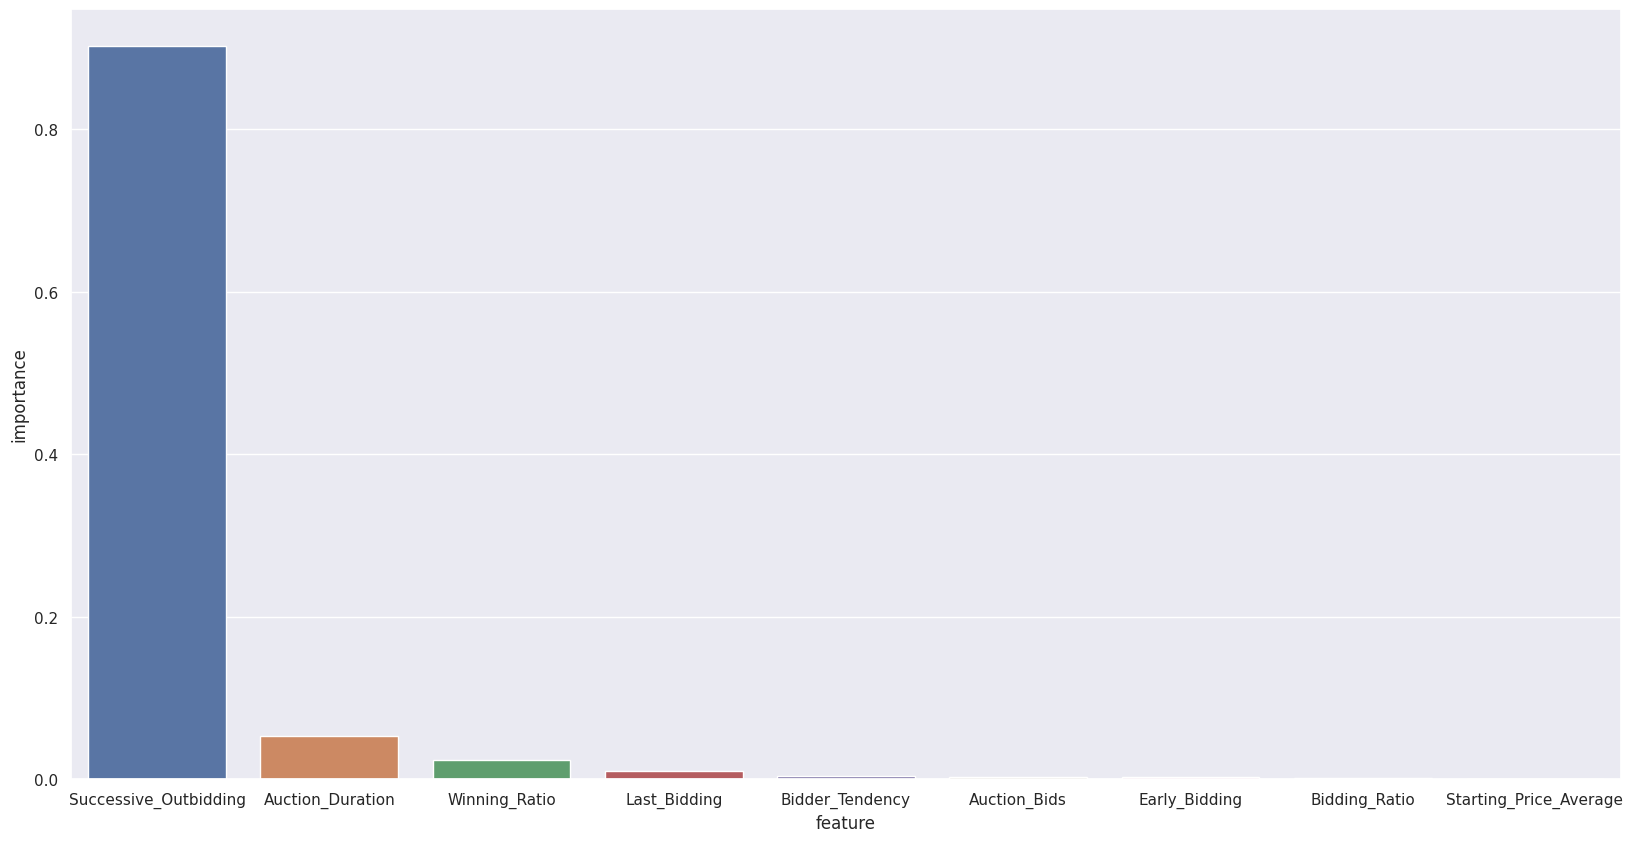

In [11]:
features = decision_tree.feature_names_in_
importances = decision_tree.feature_importances_

feature_importances = []
for i, feature in enumerate(features):
    feature_importances.append({
        "feature": feature,
        "importance": round(importances[i], 3)
    })

feature_importances = sorted(feature_importances, key=lambda x: x["importance"], reverse=True)
feature_importances = feature_importances[:15]

print("Feature Importances:")
seaborn.set(rc={'figure.figsize':(20,10)})
seaborn.barplot(data=pandas.DataFrame(feature_importances), x="feature", y="importance")